In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score,StratifiedKFold
import xgboost as xgb
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score,f1_score, confusion_matrix
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer,KNNImputer
from lightgbm import LGBMClassifier
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
# sklearn tools and models
from imblearn.over_sampling import SMOTE
import lightgbm as lgbm
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np

import os

import optuna
import warnings
warnings.filterwarnings("ignore")

In [62]:
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')
data_sample = pd.read_csv('sample_submission.csv')

In [63]:
expense_columns = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']

data_train['expense_columns'] = data_train[expense_columns].fillna(0).sum(axis=1)

# Split the PassengerId into group and number within the group
data_train[['group', 'number_within_group']] = data_train['PassengerId'].str.split('_', expand=True)

# Fill missing Cabin values based on the most common Cabin in the same group
for group_name, group in data_train.groupby('group'):
    most_common_cabin = group['Cabin'].dropna().mode()
    if len(most_common_cabin) > 0:
        most_common_cabin = most_common_cabin[0]
        if group['Cabin'].dropna().value_counts().iloc[0] > group['Cabin'].isnull().sum():
            data_train.loc[(data_train['group'] == group_name) & (data_train['Cabin'].isnull()), 'Cabin'] = most_common_cabin
        elif len(group['Cabin'].unique()) - 1 == group['Cabin'].isnull().sum():
            different_cabin = group['Cabin'].dropna().value_counts().index[-1]
            data_train.loc[(data_train['group'] == group_name) & (data_train['Cabin'].isnull()), 'Cabin'] = different_cabin

# Fill missing HomePlanet values based on the most common HomePlanet in the same group
homeplanet_mode_per_group = data_train.groupby('group')['HomePlanet'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
homeplanet_mode_map = homeplanet_mode_per_group.to_dict()
data_train['HomePlanet'] = data_train.apply(lambda row: homeplanet_mode_map[row['group']] if pd.isna(row['HomePlanet']) else row['HomePlanet'], axis=1)

# Handle CryoSleep logic related to expenses
data_train.loc[data_train['CryoSleep'].isnull() & (data_train['expense_columns'] == 0), 'CryoSleep'] = True
data_train.loc[data_train['CryoSleep'].isnull() & (data_train['expense_columns'] > 0), 'CryoSleep'] = False

# Recalculate Expenses to ensure it's correct (especially after handling CryoSleep)
data_train['Expenses'] = data_train[expense_columns].sum(axis=1)

# Update CryoSleep status based on Expenses
data_train.loc[:, ['CryoSleep']] = data_train.apply(lambda x: True if x.Expenses == 0 and pd.isna(x.CryoSleep) else x, axis=1)

# Fill missing names with a placeholder
data_train['Name'].fillna('Unknown Unknown', inplace=True)

# Extract group number from PassengerId
data_train.loc[:, ['Room']] = data_train['PassengerId'].apply(lambda x: x[0:4])


In [64]:
# Removed Nan & duplicates. This is to ensure we are working with a subset of the data that is relevant
guide_VIP = data_train.loc[:, ['Room','VIP']].dropna().drop_duplicates('Room')
guide_Cabin = data_train.loc[:, ['Room','Cabin']].dropna().drop_duplicates('Room')
guide_HomePlanet = data_train.loc[:, ['Room','HomePlanet']].dropna().drop_duplicates('Room')
guide_Destination = data_train.loc[:, ['Room','Destination']].dropna().drop_duplicates('Room')


In [65]:
# Based on the room number, it will associate with VIP, Cabin, HomePlanet and guide destination
data_train = pd.merge(data_train, guide_Cabin, how="left", on='Room', suffixes=('','_y'))
data_train = pd.merge(data_train, guide_VIP, how="left", on='Room', suffixes=('','_y'))
data_train = pd.merge(data_train, guide_HomePlanet, how="left", on='Room', suffixes=('','_y'))
data_train = pd.merge(data_train, guide_Destination, how="left", on='Room', suffixes=('','_y'))


In [66]:
# Update the columns if the original colums is NaN
data_train.loc[:, ['VIP']] = data_train.apply(lambda x: x.VIP_y if pd.isna(x.VIP) else x, axis=1)
data_train.loc[:, ['Cabin']] = data_train.apply(lambda x:  x.Cabin_y if pd.isna(x.Cabin) else x, axis=1)
data_train.loc[:, ['HomePlanet']] = data_train.apply(lambda x:  x.HomePlanet_y if pd.isna(x.HomePlanet) else x, axis=1)
data_train.loc[:, ['Destination']] = data_train.apply(lambda x:  x.Destination_y if pd.isna(x.Destination) else x, axis=1)


In [67]:
data_train[["cabin_code","id_cabin","cabin_sector"]] = data_train["Cabin"].str.split("/", n=2, expand=True)
data_train.head(5)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,number_within_group,Expenses,Room,Cabin_y,VIP_y,HomePlanet_y,Destination_y,cabin_code,id_cabin,cabin_sector
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.00,False,0.00,0.00,0.00,...,01,0.00,0001,B/0/P,False,Europa,TRAPPIST-1e,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.00,False,109.00,9.00,25.00,...,01,736.00,0002,F/0/S,False,Earth,TRAPPIST-1e,F,0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.00,True,43.00,3576.00,0.00,...,01,10383.00,0003,A/0/S,True,Europa,TRAPPIST-1e,A,0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.00,False,0.00,1283.00,371.00,...,02,5176.00,0003,A/0/S,True,Europa,TRAPPIST-1e,A,0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.00,False,303.00,70.00,151.00,...,01,1091.00,0004,F/1/S,False,Earth,TRAPPIST-1e,F,1,S


In [68]:
# Split Name into First Name & Last Name
data_train.loc[:, ['FirstName']] = data_train.Name.str.split(" ", expand=True).iloc[:, 0]
data_train.loc[:, ['SecondName']] = data_train.Name.str.split(" ", expand=True).iloc[:, 1]

# Adding a new column "Name_key" with second name and room number
data_train['Name_key'] = data_train['SecondName'] + data_train['Room']


In [69]:
from sklearn.impute import SimpleImputer

numerical_imputer = SimpleImputer(strategy='mean')
categorical_imputer = SimpleImputer(strategy='most_frequent')

# Selecting the features we want to use for numerical and categorical.
numerical_cols = ['ShoppingMall','FoodCourt','RoomService','Spa','VRDeck','Expenses','Age']
categorical_cols = ['CryoSleep','cabin_code','cabin_sector','VIP','HomePlanet','Destination']
transported = ['Transported']

# Making a copy of data_train
data_train = data_train[numerical_cols + categorical_cols + transported].copy()

# Using mean of the respective column in the event a data is missing numerical value
# Using Most frequent value in the event a column is missing a category value
data_train[numerical_cols] = pd.DataFrame(numerical_imputer.fit_transform(data_train[numerical_cols]), columns=numerical_cols)
data_train[categorical_cols] = pd.DataFrame(categorical_imputer.fit_transform(data_train[categorical_cols]), columns=categorical_cols)

# We can see now our data columns are mostly filled and no longer Nan except cabin_side
data_train.isna().sum()


ShoppingMall     0
FoodCourt        0
RoomService      0
Spa              0
VRDeck           0
Expenses         0
Age              0
CryoSleep        0
cabin_code       0
cabin_sector    99
VIP              0
HomePlanet       0
Destination      0
Transported      0
dtype: int64

In [70]:
from sklearn.preprocessing import OneHotEncoder

# Initialize the OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')

# Fit and transform the categorical data and convert to a DataFrame
encoded_data = encoder.fit_transform(data_train[categorical_cols])
df_train_temp = pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names_out())

# Drop the original categorical columns from data_train
data_train = data_train.drop(categorical_cols, axis=1)

# Concatenate the encoded categorical data with the rest of data_train
data_train = pd.concat([data_train, df_train_temp], axis=1)

# Convert back to training and testing dataset
df_train = data_train[data_train['Transported'].notnull()].copy()
df_train['Transported'] = df_train['Transported'].astype('int')

df_test = data_train[data_train['Transported'].isnull()].drop("Transported", axis=1)
print(df_test)


Empty DataFrame
Columns: [ShoppingMall, FoodCourt, RoomService, Spa, VRDeck, Expenses, Age, CryoSleep_False, CryoSleep_True, cabin_code_A, cabin_code_B, cabin_code_C, cabin_code_D, cabin_code_E, cabin_code_F, cabin_code_G, cabin_code_T, cabin_sector_P, cabin_sector_S, cabin_sector_None, VIP_False, VIP_True, HomePlanet_Earth, HomePlanet_Europa, HomePlanet_Mars, Destination_55 Cancri e, Destination_PSO J318.5-22, Destination_TRAPPIST-1e]
Index: []

[0 rows x 28 columns]


In [50]:
# Final training data
X = df_train.drop('Transported',axis=1)
y = df_train.Transported

# Shuffling the datasets of X & y to prevent biases
X, y = shuffle(X, y)
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

drop_list=['ShoppingMall','Age','CryoSleep_True','HomePlanet_Earth','HomePlanet_Europa',
            'VIP_True','HomePlanet_Mars','Destination_PSO J318.5-22','VIP_False',
            'Destination_55 Cancri e','FoodCourt','Destination_TRAPPIST-1e']

X = X.drop(drop_list, axis=1)
df_test = df_test.drop(drop_list, axis=1)
print(df_test)

In [51]:
# Balancing the datasets
smote = SMOTE(sampling_strategy=1, n_jobs=-1)
X_sm, y_sm = smote.fit_resample(X, y)
X = X_sm
y = y_sm

In [53]:

from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

# Now you can use X_train, X_test, y_train, and y_test in your model fitting


Data_train_tr3 Accuracy: 0.7779680365296804
Confusion Matrix:
[[669 189]
 [200 694]]
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.78      0.77       858
           1       0.79      0.78      0.78       894

    accuracy                           0.78      1752
   macro avg       0.78      0.78      0.78      1752
weighted avg       0.78      0.78      0.78      1752



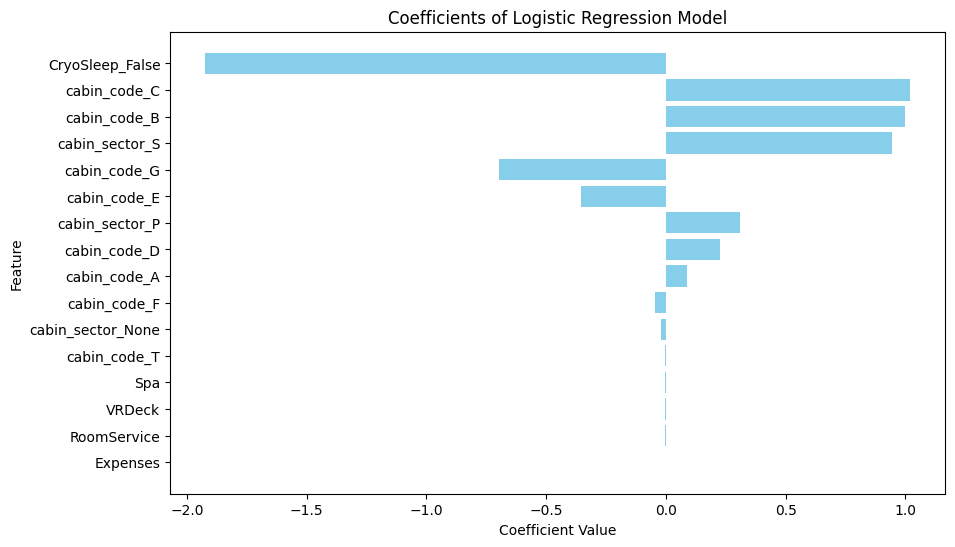

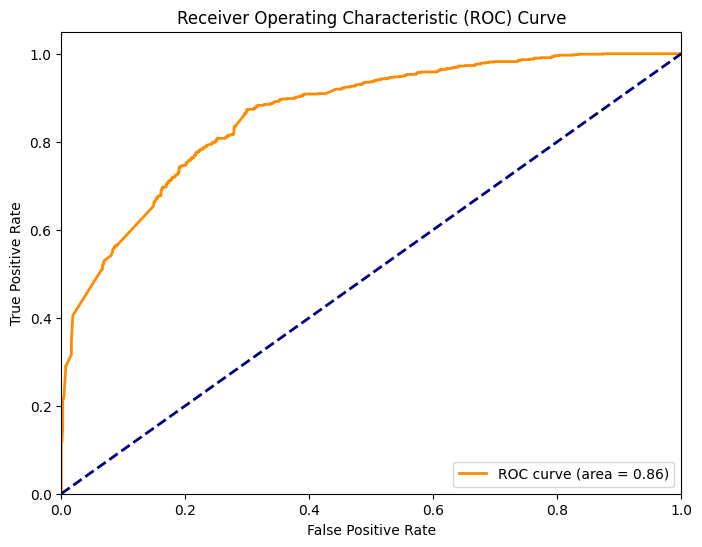

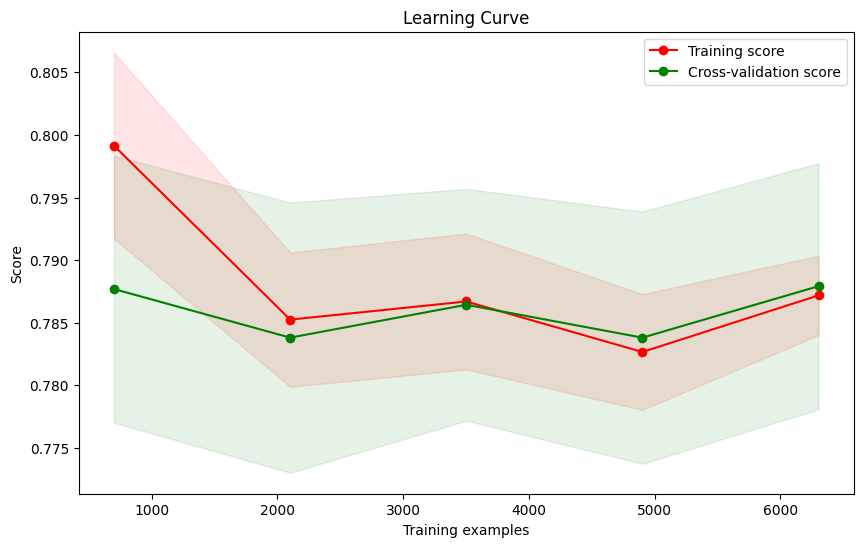

In [55]:
logistic_regression_model = LogisticRegression()
logistic_regression_model.fit(X_train, y_train)

y_pred = logistic_regression_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

print("Data_train_tr3 Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion_mat)

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Obtenez les noms des caractéristiques
feature_names = X.columns

# Obtenez les coefficients du modèle
coefficients = logistic_regression_model.coef_[0]

# Triez les coefficients par valeur absolue pour une visualisation plus claire
sorted_indices = np.argsort(np.abs(coefficients))
sorted_feature_names = feature_names[sorted_indices]
sorted_coefficients = coefficients[sorted_indices]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_coefficients)), sorted_coefficients, color='skyblue')
plt.yticks(range(len(sorted_coefficients)), sorted_feature_names)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Coefficients of Logistic Regression Model')
plt.show()

# Calculer les probabilités prédites pour les données de test
y_prob = logistic_regression_model.predict_proba(X_test)[:, 1]

# Calculer la courbe ROC et l'aire sous la courbe
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Tracer la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Tracer la courbe d'apprentissage
train_sizes, train_scores, valid_scores = learning_curve(logistic_regression_model, X, y, train_sizes=[0.1, 0.3, 0.5, 0.7, 0.9], cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, valid_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Learning Curve")
plt.legend(loc="best")


In [56]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Initialize XGBClassifier
model = XGBClassifier()

# Entraîner le modèle sur les données d'entraînement
model.fit(X_train, y_train)

# Faire des prédictions sur les données de test
y_pred = model.predict(X_test)

# Calculer l'exactitude du modèle
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.7916666666666666


In [58]:
from catboost import CatBoostClassifier

#modelling
gcv=GridSearchCV(CatBoostClassifier(),param_grid={'iterations': range(200,2000,200), 'eval_metric': ['Accuracy'],'verbose':[0]},cv=3)
gcv.fit(X, y)
y_pred = gcv.predict(df_test)

No objects info loaded


In [59]:
submission = pd.read_csv('/kaggle/input/spaceship-titanic/sample_submission.csv')
submission['Transported'] = y_pred
submission['Transported'] = submission['Transported'] > 0.5

submission.to_csv('submission.csv', index=False)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/spaceship-titanic/sample_submission.csv'